In [5]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

In [30]:
abq = io.imread('val_veny.jpg')

In [31]:
abq_re = abq.reshape(-1,3, order = 'F')

In [33]:
(colors, counts) = np.unique(abq_re, axis = 0, return_counts = True)

In [10]:
colors[counts.argmax()]

array([255, 255, 255], dtype=uint8)

In [11]:
abq[(abq[:,:,0]==254)&(abq[:,:,1]==254)&(abq[:,:,2]==254)] = [255,0,255]

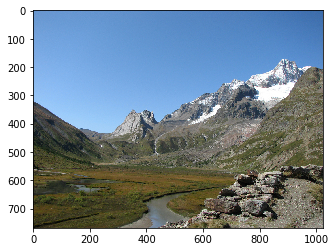

In [32]:
plt.imshow(abq)

In [17]:
colors.shape

(103434, 3)

In [9]:
counts.shape

(67469,)

In [35]:
counts = counts.reshape(-1,1)

In [36]:
counts.shape

(103434, 1)

In [37]:
colcounts = np.hstack([colors, counts]) #adds the counts as the fourth row

In [38]:
index = np.arange(0,colors.shape[0])

In [39]:
index = index.reshape(-1,1)

In [40]:
colcounts = np.hstack([colcounts, index])

In [41]:
colcounts.shape # row 3 - number of occurences, row 4 - index (to recreate later)

(103434, 5)

In [42]:
np.max(colcounts[:,3])

1929

In [44]:
np.unique(colcounts[:,3], return_counts = True)

(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
          34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
          45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
          56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
          67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
          78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
          89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
         100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
         111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
         122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
         133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
         144,  145,  146,  147,  148, 

In [45]:
a = np.random.randint(0,9, size = (10,1))

In [46]:
b = np.random.randint(0,9, size = (10,1))

In [47]:
c = np.random.randint(0,9, size = (10,1))

In [52]:
abc = np.hstack([a,b,c])

In [53]:
abc.shape

(10, 3)

In [55]:
abc

array([[6, 4, 0],
       [2, 3, 3],
       [7, 0, 8],
       [5, 6, 3],
       [2, 5, 0],
       [0, 3, 8],
       [4, 3, 4],
       [4, 7, 3],
       [3, 0, 5],
       [4, 4, 0]])

In [54]:
abc[abc[:,1].argsort()] #sorts by the second column

array([[7, 0, 8],
       [3, 0, 5],
       [2, 3, 3],
       [0, 3, 8],
       [4, 3, 4],
       [6, 4, 0],
       [4, 4, 0],
       [2, 5, 0],
       [5, 6, 3],
       [4, 7, 3]])

In [197]:
def freqmap(image):
    image_res = image.reshape(-1,3, order = 'F')
    # (colors, counts) = np.unique(image_res, axis = 0, return_counts = True)
    (colors, idx, counts) = np.unique(image_res, axis = 0, return_counts = True, return_inverse = True)
    # counts = counts.reshape(-1,1)
    #idx = idx.reshape(-1,1)
    #counts = counts.reshape(-1,1)
    freqs = counts[idx[:]]
    freq_factor = 255/np.max(freqs)
    freqs = freqs.reshape(-1,1)
    image_freqs = np.hstack([image_res, freqs])
    #freq_factor = 255/np.max(image_freqs[:,3])
    #freqmap = [image_freqs[:,0], image_freqs[:,1], image_freqs[:,2]]*image_freqs[:,3]*freq_factor
    freqmap = [image_freqs[:,3]*freq_factor, image_freqs[:,3]*freq_factor, image_freqs[:,3]*freq_factor]
    return freqmap
                             
    # I need to have the original image with the pixel count by each single pixel
    # or somehow make a lookup in the counts table
    

In [198]:
testabq = freqmap(abq)

In [199]:
testabq.shape

AttributeError: 'list' object has no attribute 'shape'

In [194]:
test_transform = testabq.T

In [195]:
test_transform.shape

(786432, 3)

In [196]:
test_transform.max()

65024.999999999993

In [156]:
abq_res = abq.reshape(-1,3, order = 'F')

In [157]:
abq_res.shape

(786432, 3)

In [158]:
(colors, idx, counts) = np.unique(abq_res, axis = 0, return_counts = True, return_inverse = True)


In [164]:
abq_res.shape

(786432, 3)

In [159]:
colors.shape

(103434, 3)

In [160]:
idx.shape

(786432,)

In [161]:
counts.shape

(103434,)

In [176]:
freqs = counts[idx[:]]

In [177]:
freqs.shape

(786432,)

In [179]:
freqs = freqs.reshape(1,-1)

In [180]:
freqs.shape

(1, 786432)

In [178]:
np.hstack([abq_res, freqs])

ValueError: all the input arrays must have same number of dimensions

In [ ]:
(col)

In [155]:
test = freqmap(abq)

IndexError: index 44917 is out of bounds for axis 0 with size 1

In [69]:
arr = np.random.randint(0,5, size = (10,3))

In [70]:
arr

array([[1, 3, 2],
       [2, 1, 4],
       [3, 2, 0],
       [3, 3, 0],
       [3, 1, 3],
       [0, 4, 3],
       [1, 2, 4],
       [4, 0, 4],
       [0, 0, 4],
       [2, 4, 2]])

In [75]:
[arr[:,0], arr[:,1]]*arr[:,2]*5

array([[10, 40,  0,  0, 45,  0, 20, 80,  0, 20],
       [30, 20,  0,  0, 15, 60, 40,  0,  0, 40]])

In [91]:
testarr = np.random.randint(0,9, size = (10,3))

In [92]:
testarr

array([[3, 8, 4],
       [8, 3, 8],
       [7, 6, 3],
       [8, 2, 3],
       [5, 7, 4],
       [7, 0, 4],
       [6, 3, 2],
       [1, 4, 7],
       [5, 0, 2],
       [2, 0, 2]])

In [94]:
testarr[:,2]

array([4, 8, 3, 3, 4, 4, 2, 7, 2, 2])

In [95]:
testarr[(testarr[:,0]==7) & (testarr[:,1]==6)][:,2]

array([3])

In [100]:
arr = np.random.randint(0,5, size = (5,2))

In [101]:
arr

array([[1, 0],
       [3, 1],
       [2, 4],
       [0, 2],
       [0, 2]])

In [102]:
testarr[testarr[:,0]==arr[:,0]]

/home/misiek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], shape=(0, 10, 3), dtype=int64)

In [105]:
testarr = np.random.randint(0,2, size = (10,3))

In [106]:
testarr

array([[1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 1],
       [1, 1, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 0]])

In [139]:
(triplets, idx, counts) = np.unique(testarr, axis = 0, return_counts = True, return_inverse = True)

In [120]:
triplets.shape

(6, 3)

In [121]:
counts.shape

(6,)

In [122]:
idx.shape

(10,)

In [123]:
idx

array([4, 0, 4, 3, 5, 1, 4, 3, 3, 2])

In [125]:
idx2 = idx.reshape(10,-1)

In [126]:
idx2.shape

(10, 1)

In [128]:
testarr2 = np.hstack([testarr, idx2])

In [130]:
triplets

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 1, 1]])

In [129]:
testarr2

array([[1, 0, 0, 4],
       [0, 0, 0, 0],
       [1, 0, 0, 4],
       [0, 1, 1, 3],
       [1, 1, 1, 5],
       [0, 0, 1, 1],
       [1, 0, 0, 4],
       [0, 1, 1, 3],
       [0, 1, 1, 3],
       [0, 1, 0, 2]])

In [134]:
testarr2[:,3]

array([4, 0, 4, 3, 5, 1, 4, 3, 3, 2])

In [140]:
counts2 = counts[testarr2[:,3]]

In [141]:
counts2

array([3, 1, 3, 3, 1, 1, 3, 3, 3, 1])

In [142]:
counts

array([1, 1, 1, 3, 3, 1])